In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
import optuna
import functools
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, brier_score_loss, f1_score,
    precision_score, recall_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from autokeras import StructuredDataClassifier
from keras.metrics import BinaryAccuracy
import keras_tuner

import miceforest as mf
from sklearn.feature_selection import RFECV
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from autoviz import data_cleaning_suggestions

%matplotlib inline

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## Functions

In [33]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [12]:
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom', rotation=90)        

# DATA IMPORTING

In [77]:
data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Master Thesis\\lending_club_loan_two.csv")

In [3]:
data.head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"
5,20000.00,36 months,13.33,677.07,C,C3,HR Specialist,10+ years,MORTGAGE,86788.00,Verified,Sep-2015,Fully Paid,debt_consolidation,Debt consolidation,16.31,Jan-2005,8.00,0.00,25757.00,100.60,23.00,f,INDIVIDUAL,4.00,0.00,"1726 Cooper Passage Suite 129\r\nNorth Deniseberg, DE 30723"
6,18000.00,36 months,5.32,542.07,A,A1,Software Development Engineer,2 years,MORTGAGE,125000.00,Source Verified,Sep-2015,Fully Paid,home_improvement,Home improvement,1.36,Aug-2005,8.00,0.00,4178.00,4.90,25.00,f,INDIVIDUAL,3.00,0.00,"1008 Erika Vista Suite 748\r\nEast Stephanie, TX 22690"
7,13000.00,36 months,11.14,426.47,B,B2,Office Depot,10+ years,RENT,46000.00,Not Verified,Sep-2012,Fully Paid,credit_card,No More Credit Cards,26.87,Sep-1994,11.00,0.00,13425.00,64.50,15.00,f,INDIVIDUAL,0.00,0.00,USCGC Nunez\r\nFPO AE 30723
8,18900.00,60 months,10.99,410.84,B,B3,Application Architect,10+ years,RENT,103000.00,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,12.52,Jun-1994,13.00,0.00,18637.00,32.90,40.00,w,INDIVIDUAL,3.00,0.00,USCGC Tran\r\nFPO AP 22690
9,26300.00,36 months,16.29,928.40,C,C5,Regado Biosciences,3 years,MORTGAGE,115000.00,Verified,Apr-2012,Fully Paid,debt_consolidation,Debt Consolidation,23.69,Dec-1997,13.00,0.00,22171.00,82.40,37.00,f,INDIVIDUAL,1.00,0.00,"3390 Luis Rue\r\nMauricestad, VA 00813"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

# FEATURE ENGINEERING AND DATA EXPLORATION

## Remove unnecessary features:

In [78]:
data.drop(['emp_title', 'title', 'earliest_cr_line', 'issue_d'], axis = 1, inplace = True)

## Create additional feature
Column 'address' contains unique address of loanees. However, as many loanees share the same zip code, we could create a new feature called zip code out of the address feature.

In [79]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data.drop('address', axis=1, inplace=True)

## Checking for potential data quality issue

In [6]:
data_cleaning_suggestions(data)

    All variables classified into correct types.


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
loan_amnt,float64,0.000000,NA,500.000000,40000.000000,Column has 191 outliers greater than upper bound (38000.00) or lower than lower bound(-10000.00). Cap them or remove them.
term,object,0.000000,0,,,No issue
int_rate,float64,0.000000,NA,5.320000,30.990000,Column has 3777 outliers greater than upper bound (25.49) or lower than lower bound(1.49). Cap them or remove them.
installment,float64,0.000000,NA,16.080000,1533.810000,"Column has 11250 outliers greater than upper bound (1042.75) or lower than lower bound(-225.12). Cap them or remove them., Column has a high correlation with ['loan_amnt']. Consider dropping one of them."
grade,object,0.000000,0,,,1 rare categories: ['G']. Group them into a single category or drop the categories.
sub_grade,object,0.000000,0,,,"10 rare categories: ['F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']. Group them into a single category or drop the categories."
emp_length,object,4.621115,0,,,"18301 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
home_ownership,object,0.000000,0,,,"3 rare categories: ['OTHER', 'NONE', 'ANY']. Group them into a single category or drop the categories."
annual_inc,float64,0.000000,NA,0.000000,8706582.000000,Column has 16700 outliers greater than upper bound (157500.00) or lower than lower bound(-22500.00). Cap them or remove them.
verification_status,object,0.000000,0,,,No issue


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
loan_amnt,float64,0.00,NA,500.00,40000.00,Column has 191 outliers greater than upper bound (38000.00) or lower than lower bound(-10000.00). Cap them or remove them.
term,object,0.00,0,,,No issue
int_rate,float64,0.00,NA,5.32,30.99,Column has 3777 outliers greater than upper bound (25.49) or lower than lower bound(1.49). Cap them or remove them.
installment,float64,0.00,NA,16.08,1533.81,"Column has 11250 outliers greater than upper bound (1042.75) or lower than lower bound(-225.12). Cap them or remove them., Column has a high correlation with ['loan_amnt']. Consider dropping one of them."
grade,object,0.00,0,,,1 rare categories: ['G']. Group them into a single category or drop the categories.
sub_grade,object,0.00,0,,,"10 rare categories: ['F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']. Group them into a single category or drop the categories."
emp_length,object,4.62,0,,,"18301 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
home_ownership,object,0.00,0,,,"3 rare categories: ['OTHER', 'NONE', 'ANY']. Group them into a single category or drop the categories."
annual_inc,float64,0.00,NA,0.00,8706582.00,Column has 16700 outliers greater than upper bound (157500.00) or lower than lower bound(-22500.00). Cap them or remove them.
verification_status,object,0.00,0,,,No issue


### Outlier issues:
outliers are detected in the following columns: loan_amnt, int_rate, installment, annual_inc, dti, open_acc, pub_rec, revol_bal, revol_util, total_acc, mort_acc, pub_rec_bankruptcies

***among these features, dti and loan_amnt contain the least number of outliers => winsorizing data is suggested. Whereas revol_util maximum value in reality is 100% so it must be capped at 100***

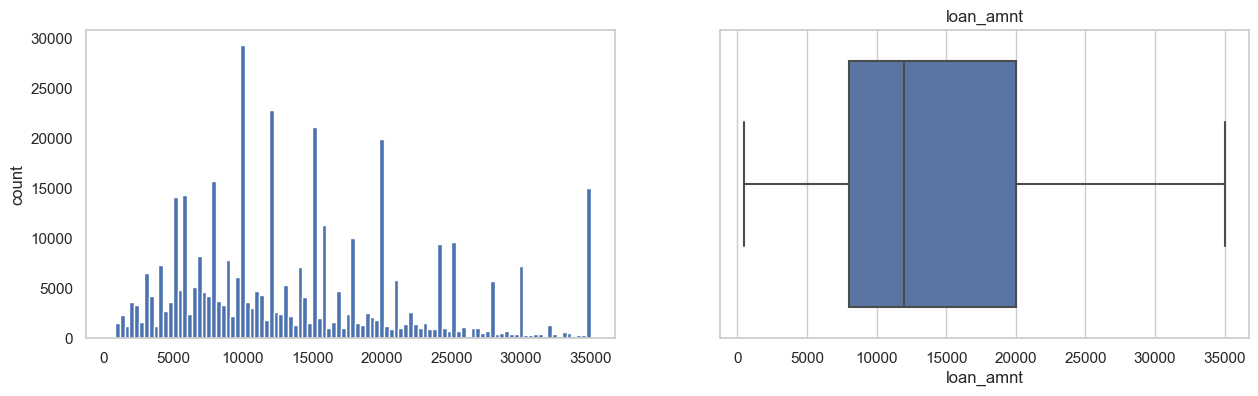

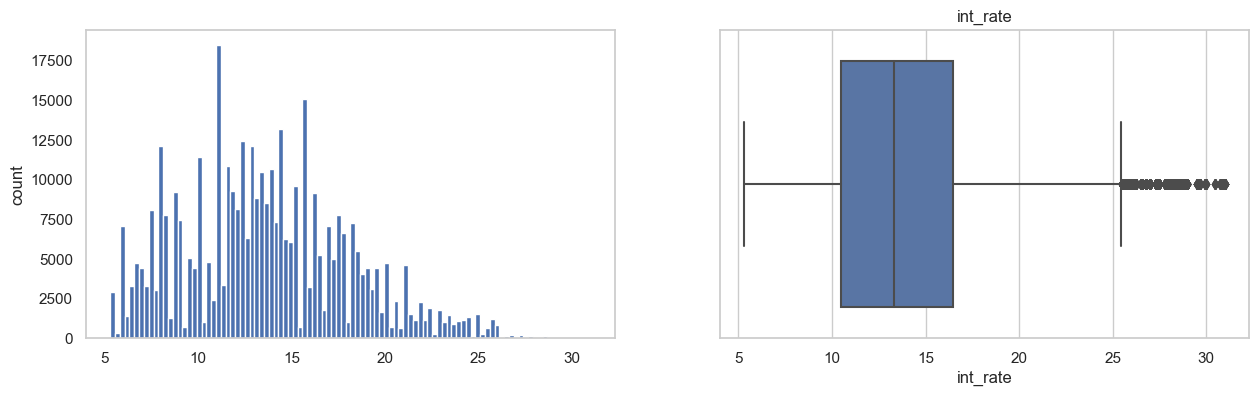

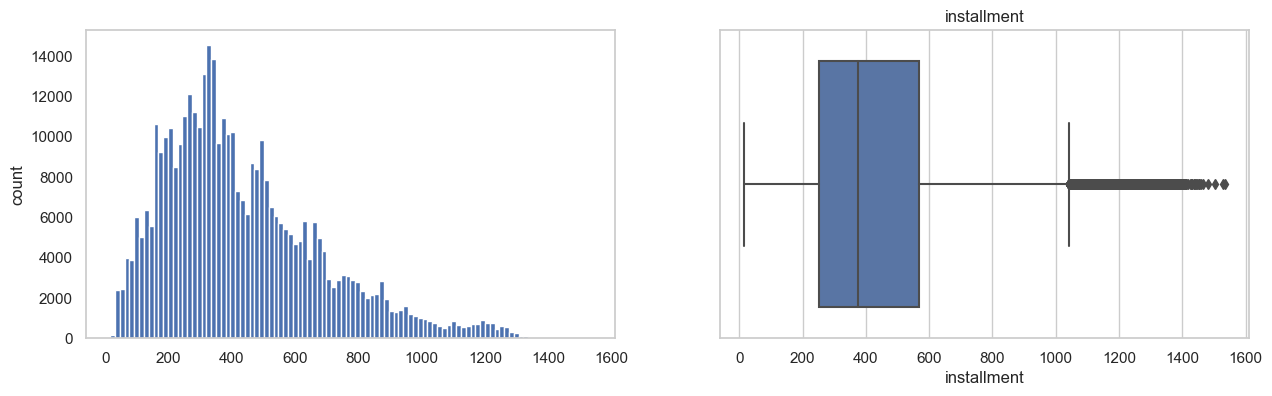

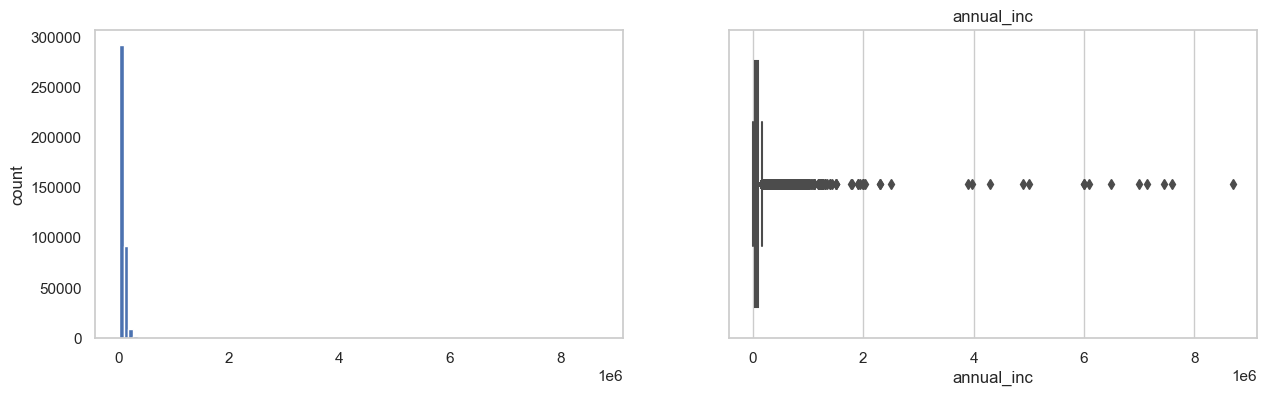

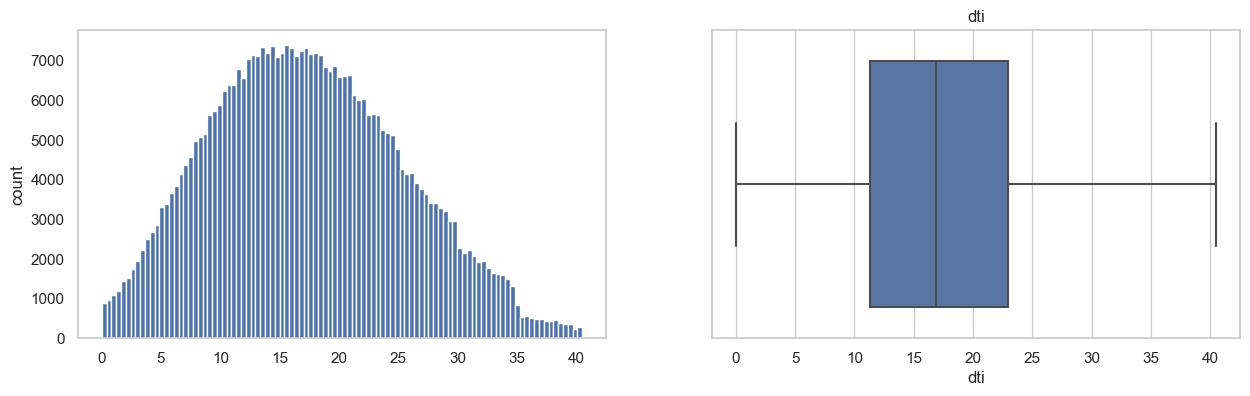

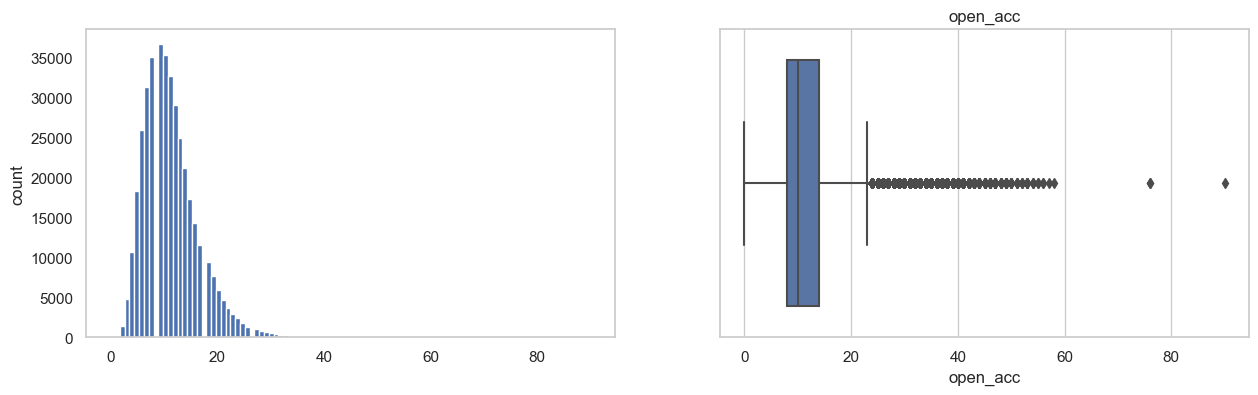

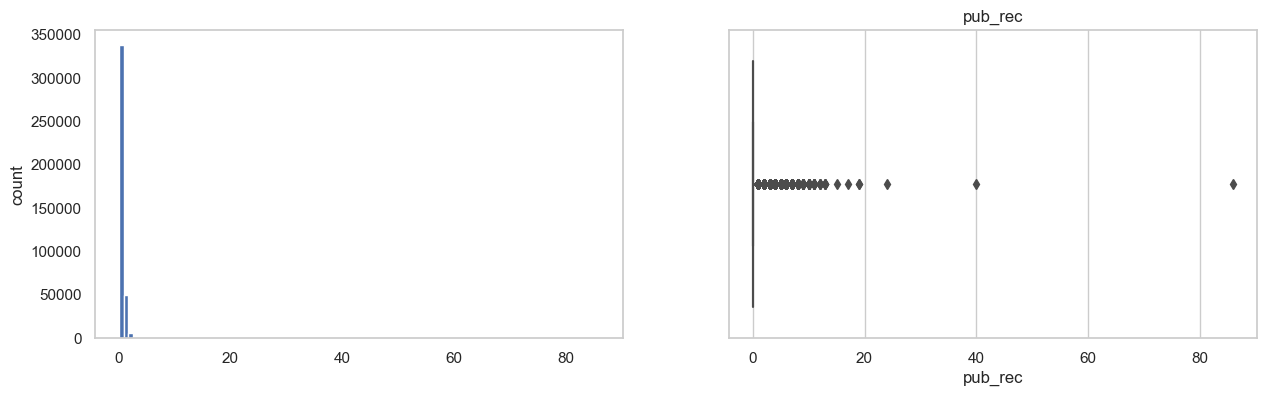

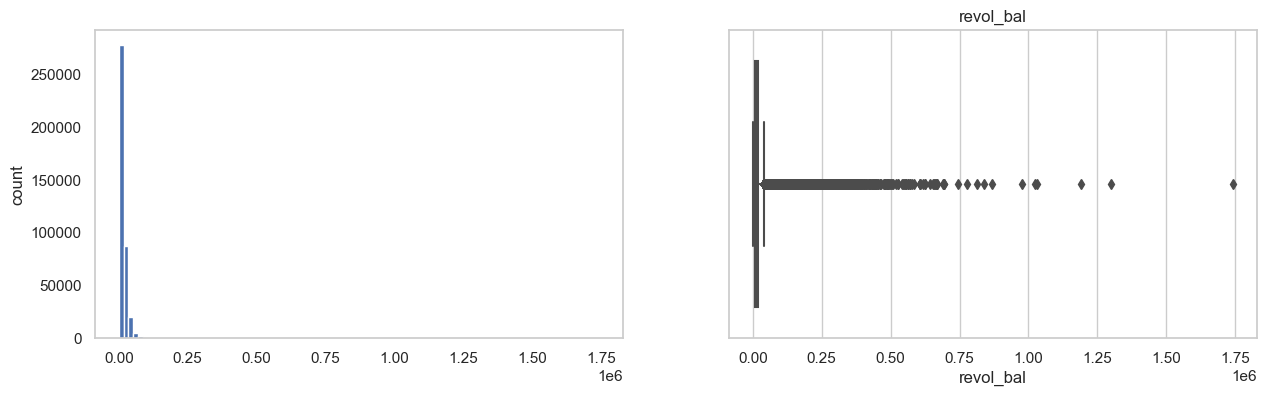

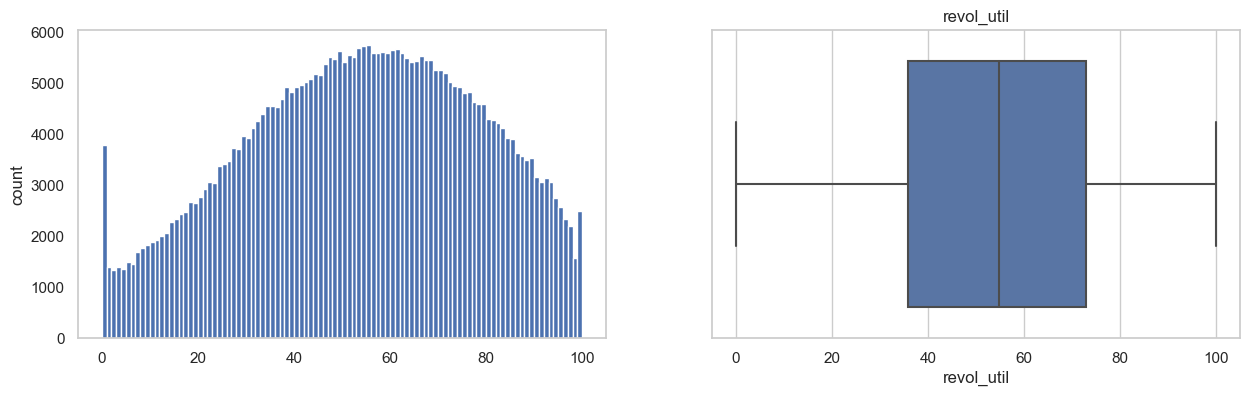

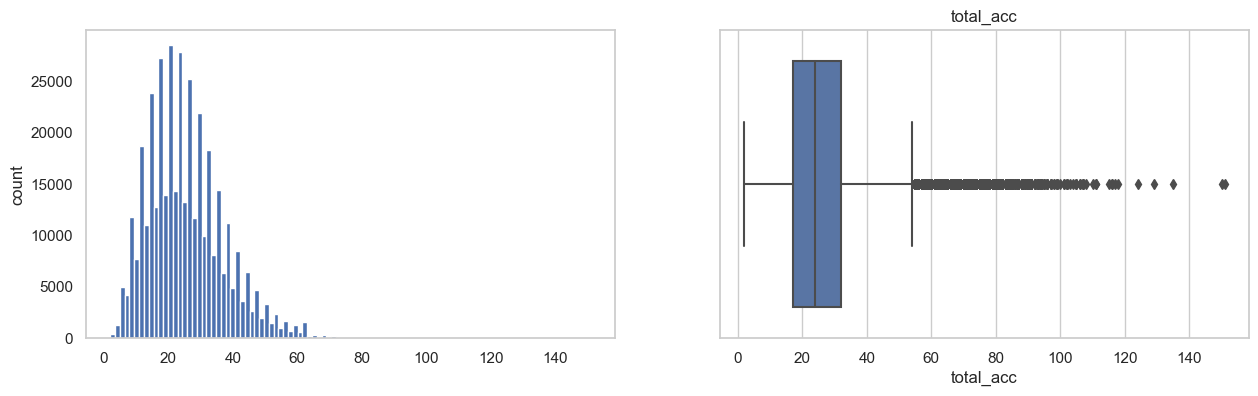

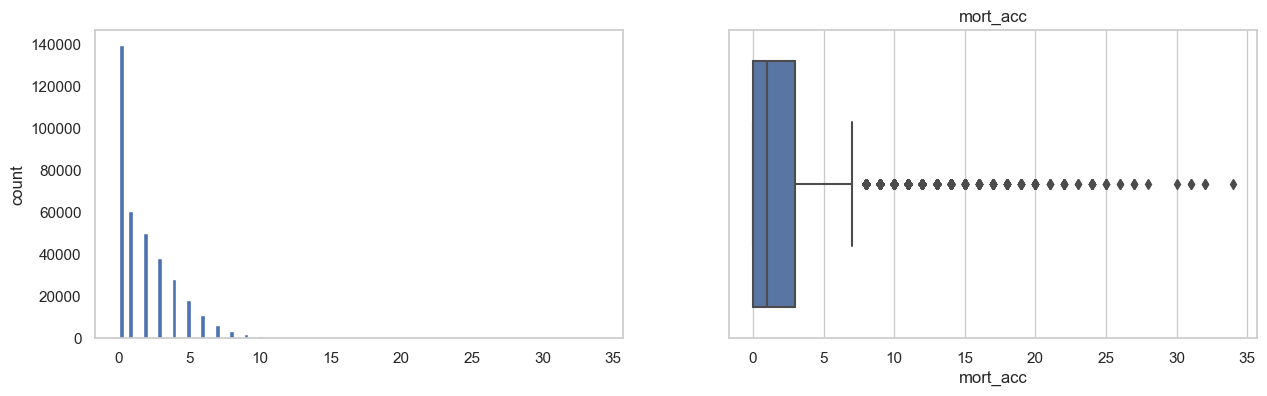

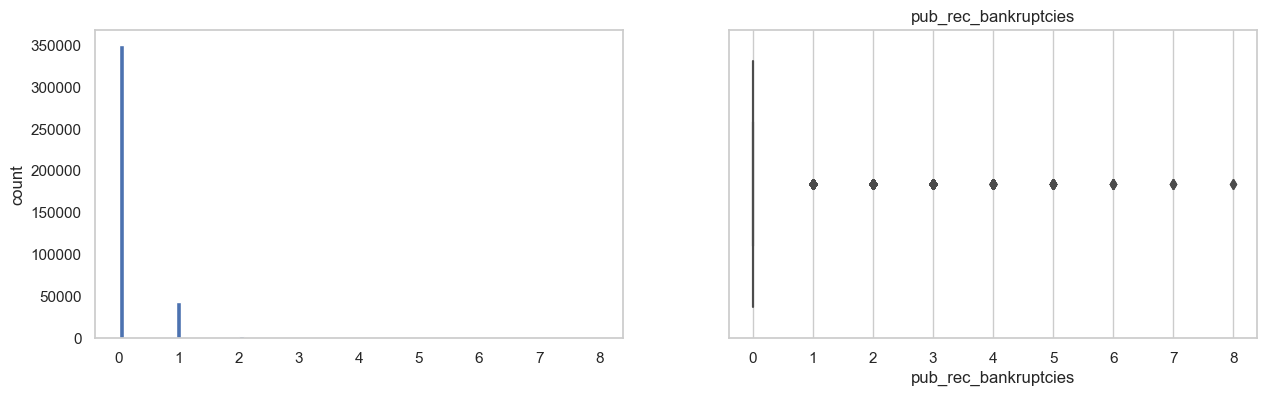

In [57]:
cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
        'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

for col in cols:
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False, bins=100)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(col)
    plt.show()

#### Winsorizing dti, loan_amnt and revol_util

In [80]:
data['loan_amnt'] = winsorize(data['loan_amnt'], limits=(0, 0.01))
data['dti'] = winsorize(data['dti'], limits=(0, 0.0007))
data.loc[data['revol_util'] >= 100, 'revol_util'] = 100 # in reality, maximum utilization is 100% and hence the variable is capped at 100%

### Features contain categories that can be grouped:
home_ownership, grade, sub_grade, home_ownership, purpose, application_type

<Axes: xlabel='home_ownership', ylabel='count'>

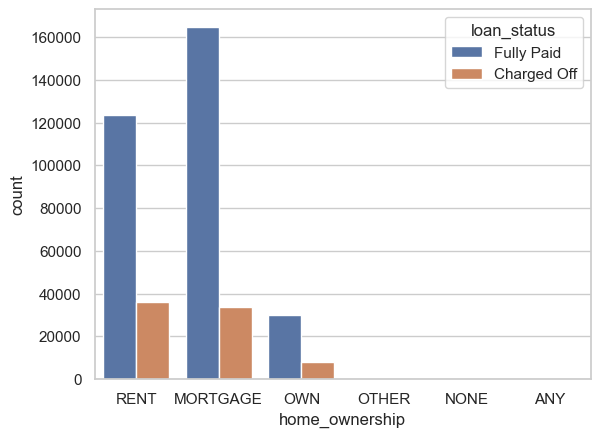

In [58]:
sns.countplot(x='home_ownership', data=data, hue='loan_status')

merging 'other', 'none' and 'any' into 1 category 'other'

In [81]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'

<Axes: xlabel='verification_status', ylabel='count'>

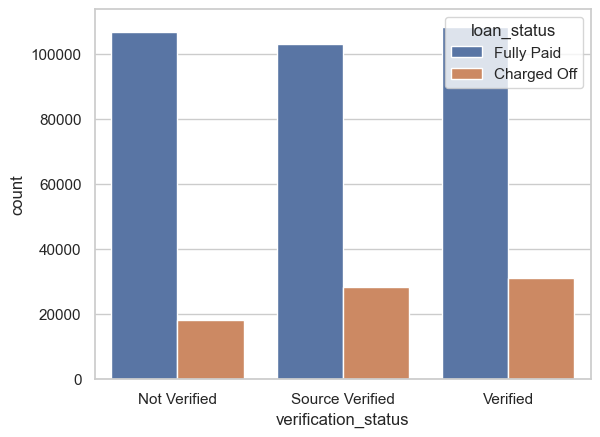

In [60]:
sns.countplot(x='verification_status', data=data, hue='loan_status')

source verified and verified as similar fully paid and charged off distribution, we will merge them into 1 category

In [82]:
data.loc[(data.verification_status == 'Source Verified'), 'verification_status'] = 'Verified'

<Axes: xlabel='grade', ylabel='count'>

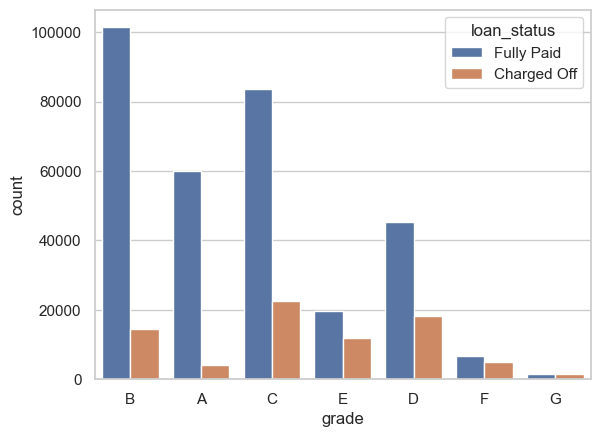

In [67]:
sns.countplot(x='grade', data=data, hue='loan_status')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, 'B4'),
  Text(1, 0, 'B5'),
  Text(2, 0, 'B3'),
  Text(3, 0, 'A2'),
  Text(4, 0, 'C5'),
  Text(5, 0, 'C3'),
  Text(6, 0, 'A1'),
  Text(7, 0, 'B2'),
  Text(8, 0, 'C1'),
  Text(9, 0, 'A5'),
  Text(10, 0, 'E4'),
  Text(11, 0, 'A4'),
  Text(12, 0, 'A3'),
  Text(13, 0, 'D1'),
  Text(14, 0, 'C2'),
  Text(15, 0, 'B1'),
  Text(16, 0, 'D3'),
  Text(17, 0, 'D5'),
  Text(18, 0, 'D2'),
  Text(19, 0, 'E1'),
  Text(20, 0, 'E2'),
  Text(21, 0, 'E5'),
  Text(22, 0, 'F4'),
  Text(23, 0, 'E3'),
  Text(24, 0, 'D4'),
  Text(25, 0, 'G1'),
  Text(26, 0, 'F5'),
  Text(27, 0, 'G2'),
  Text(28, 0, 'C4'),
  Text(29, 0, 'F1'),
  Text(30, 0, 'F3'),
  Text(31, 0, 'G5'),
  Text(32, 0, 'G4'),
  Text(33, 0, 'F2'),
  Text(34, 0, 'G3')])

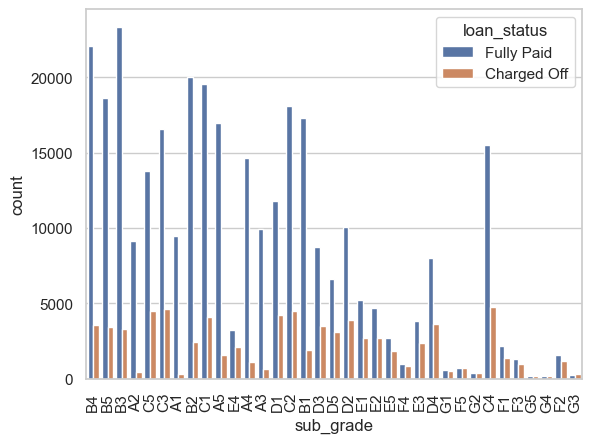

In [72]:
sns.countplot(x='sub_grade', data=data, hue='loan_status')
plt.xticks(rotation=90)

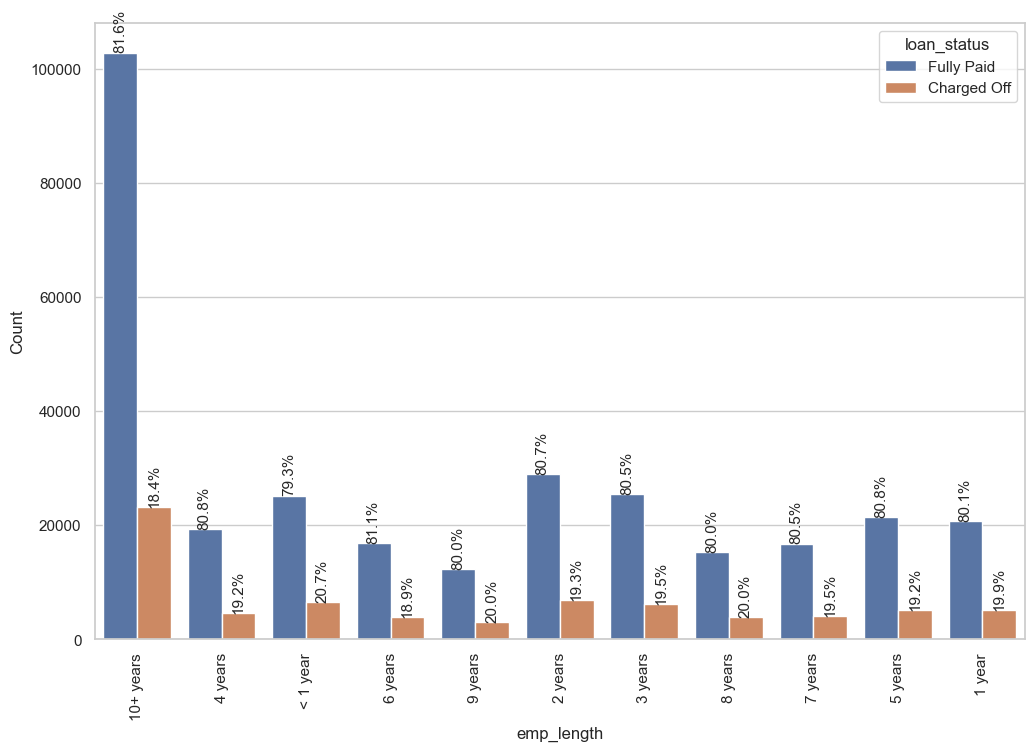

In [83]:
plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x="emp_length", hue="loan_status", data=data)
ax3.set(xlabel='emp_length', ylabel='Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
percentage_above_bar_relative_to_xgroup(ax3)
plt.show()

Most of the loans fall under 10 year+ bucket. Majority of the categories have fully_paid/charged-off ratio hoovers around 8/2, thus making emp_length as a feature less useful

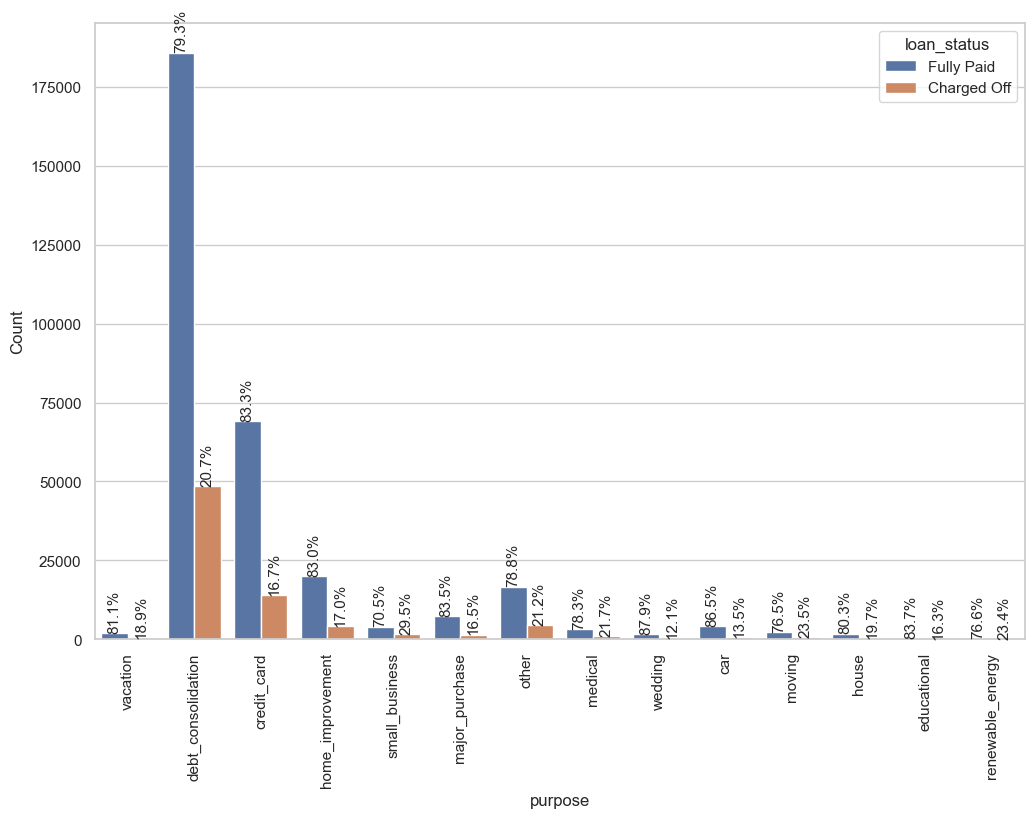

In [13]:
plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x="purpose", hue="loan_status", data=data)
ax3.set(xlabel='purpose', ylabel='Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
percentage_above_bar_relative_to_xgroup(ax3)
plt.show()

<Axes: xlabel='application_type', ylabel='count'>

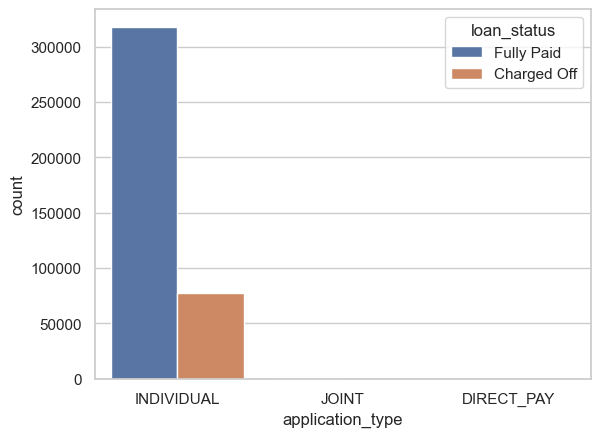

In [75]:
sns.countplot(x='application_type', data=data, hue='loan_status')

There arent many observations for Joint and Direct Pay. As a result, we opt out to use application type as a feature for our models

<Axes: xlabel='initial_list_status', ylabel='count'>

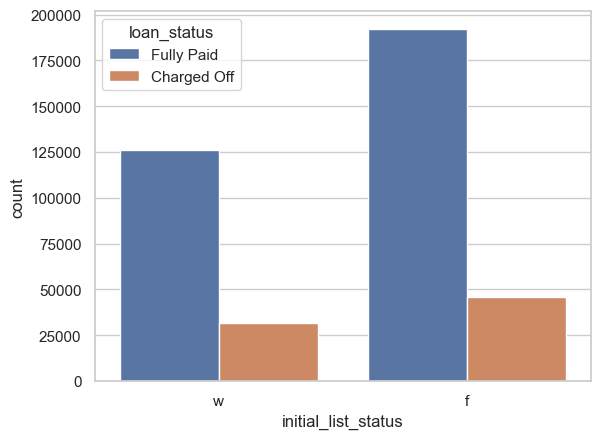

In [76]:
sns.countplot(x='initial_list_status', data=data, hue='loan_status')

### Further drop less useful features:

In [14]:
drop_vars = ['sub_grade', 'emp_length', 'application_type']
data.drop(drop_vars, axis = 1, inplace = True)

### Assign 1 for charged off and 0 for fully paid

In [15]:
data['loan_status'] = data['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

## Create train/test data sets:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('loan_status', axis=1), data['loan_status'], test_size=0.2, random_state=42)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)
X_test.drop('index', axis=1, inplace=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Encoding categorical variables using CatBoost Encoder:

In [17]:
encoder = CatBoostEncoder(verbose=1, handle_missing='value', handle_unknown='value')
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

## Missing values:
missing values are detected in the following columns: emp_length, revol_util, mort_acc, pub_rec_bankruptcies

### Data imputation for features with missing values with MICE

In [18]:
# Training data:
kds = mf.ImputationKernel(
  X_train_encoded,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 5 iterations - the more iteration the more accurate imputation. Recommended number of iteration is 5.
kds.mice(5)

# Return the completed dataset.
X_train_encoded = kds.complete_data()

In [19]:
# Testing data:
kds = mf.ImputationKernel(
  X_test_encoded,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 5 iterations - the more iteration the more accurate imputation. Recommended number of iteration is 5.
kds.mice(5)

# Return the completed dataset.
X_test_encoded = kds.complete_data()

## Data scaling:
Robust Scaler is used as the data contains a lot of outliers

In [20]:
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), 
                            columns = X_train_encoded.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), 
                           columns = X_test_encoded.columns)

## Feature selection:
### Checking for correlation among variables:

<Axes: >

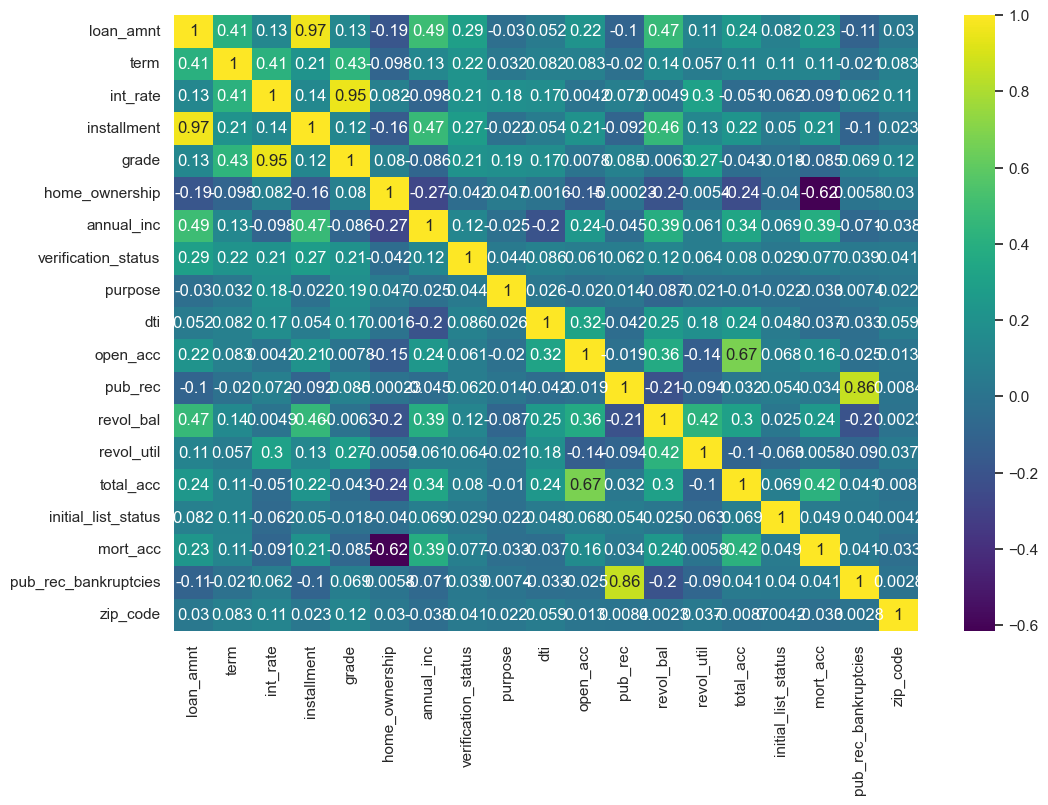

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train_scaled.corr(method='spearman'), annot=True, cmap='viridis')

pair of highly correlated features:
* installment & loan_amnt
* grade & int_rate
* pub_rec_bankcruptcies & pub_rec

### Checking for multicollinearity among variables

In [88]:
X_const = add_constant(X_train_scaled)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Print the VIF values
print(vif_data)

          Variable         VIF
0                  const  6.90
1              loan_amnt 58.70
2                   term  6.63
3               int_rate 11.18
4            installment 51.08
5                  grade 10.41
6         home_ownership  1.36
7             annual_inc  1.32
8    verification_status  1.15
9                purpose  1.04
10                   dti  1.32
11              open_acc  2.16
12               pub_rec  1.92
13             revol_bal  1.34
14            revol_util  1.30
15             total_acc  2.33
16   initial_list_status  1.05
17              mort_acc  1.63
18  pub_rec_bankruptcies  1.95
19              zip_code  1.04


High VIF (>10) observed for loan_amnt, installment, int_rate and grade
### We perform mutual information regression to check which features provide more saying to the target variable

In [89]:
mi = mutual_info_regression(X_train_scaled, y_train)

# Create a dataframe to store the mutual information scores for each feature
mi_df = pd.DataFrame({'feature': X_train_scaled.columns, 'MI score': mi})
mi_df = mi_df.sort_values(by=['MI score'], ascending=False)
print(mi_df.head(20))

          feature         MI score
18              zip_code    0.21  
2               int_rate    0.04  
4                  grade    0.03  
3            installment    0.02  
1                   term    0.01  
9                    dti    0.01  
0              loan_amnt    0.01  
13            revol_util    0.01  
7    verification_status    0.00  
6             annual_inc    0.00  
5         home_ownership    0.00  
11               pub_rec    0.00  
17  pub_rec_bankruptcies    0.00  
8                purpose    0.00  
10              open_acc    0.00  
16              mort_acc    0.00  
12             revol_bal    0.00  
14             total_acc    0.00  
15   initial_list_status    0.00  


For a pair of highly correlated variables, drop the one with lower MI score which are in this case: 'grade' and 'loan_amnt'

In [22]:
X_train_drop = X_train_scaled.drop(['grade', 'loan_amnt'], axis=1)

Re-perform VIF to check if multicollinearity is still a problem:

In [91]:
X_const = add_constant(X_train_drop)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)

          Variable        VIF
0                  const 5.37
1                   term 1.35
2               int_rate 1.57
3            installment 1.35
4         home_ownership 1.36
5             annual_inc 1.32
6    verification_status 1.15
7                purpose 1.04
8                    dti 1.31
9               open_acc 2.15
10               pub_rec 1.92
11             revol_bal 1.33
12            revol_util 1.29
13             total_acc 2.33
14   initial_list_status 1.04
15              mort_acc 1.63
16  pub_rec_bankruptcies 1.95
17              zip_code 1.04


Since pub_rec and pub_rec_bankruptcies have high correlation (0.86) => drop pub_rec_bankruptcies due to lower MI score and higher VIF score.

In [23]:
X_train_drop = X_train_scaled.drop(['grade', 'loan_amnt', 'pub_rec_bankruptcies'], axis=1)
X_test_drop = X_test_scaled.drop(['grade', 'loan_amnt', 'pub_rec_bankruptcies'], axis=1)

# MODEL TRAINING AND EVALUATION

### Neural Network, Catboost, Extra Tree, LightGBM, Logistic Regression, Random Forest

* ***flaml*** library covers the following models: Catboost, Extra Tree, LightGBM, Logistic Regression, Random Forest
* ***autokeras*** covers neural network


Epoch 1/5
9901/9901 [==============================] - 25s 2ms/step - loss: 0.3055 - accuracy: 0.8777
Epoch 2/5
9901/9901 [==============================] - 23s 2ms/step - loss: 0.2669 - accuracy: 0.8881
Epoch 3/5
9901/9901 [==============================] - 23s 2ms/step - loss: 0.2657 - accuracy: 0.8882
Epoch 4/5
9901/9901 [==============================] - 23s 2ms/step - loss: 0.2650 - accuracy: 0.8885
Epoch 5/5
9901/9901 [==============================] - 23s 2ms/step - loss: 0.2647 - accuracy: 0.8884
INFO:tensorflow:Assets written to: C:\Users\Lenovo\Desktop\Master Thesis\Best Params\structured_data_classifier\best_model\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\Desktop\Master Thesis\Best Params\structured_data_classifier\best_model\assets


9901/9901 [==============================] - 20s 2ms/step


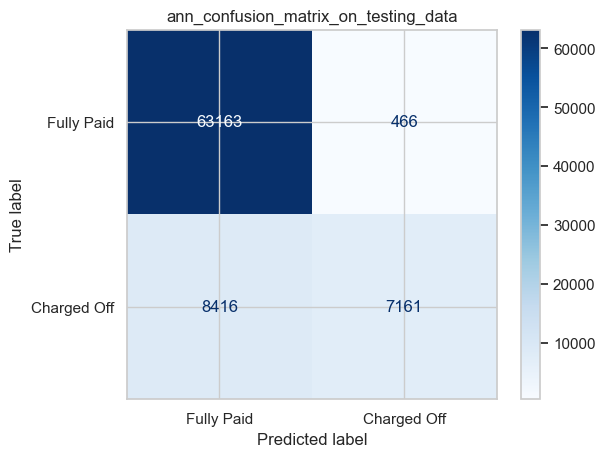

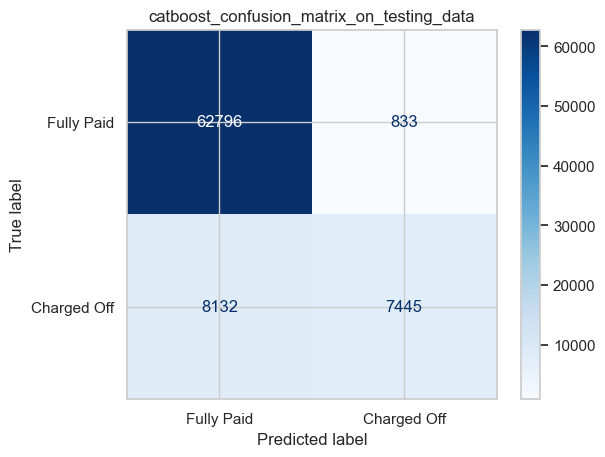

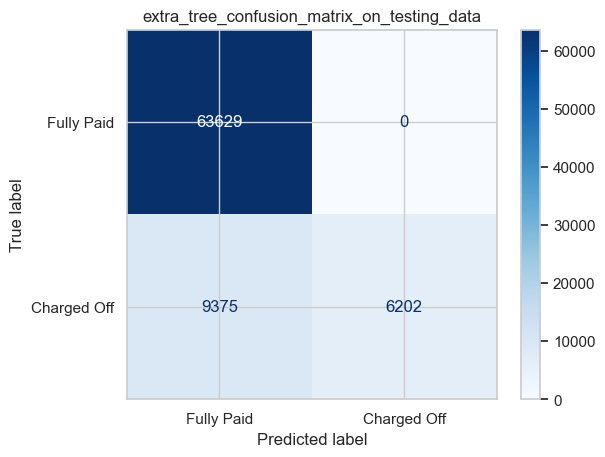

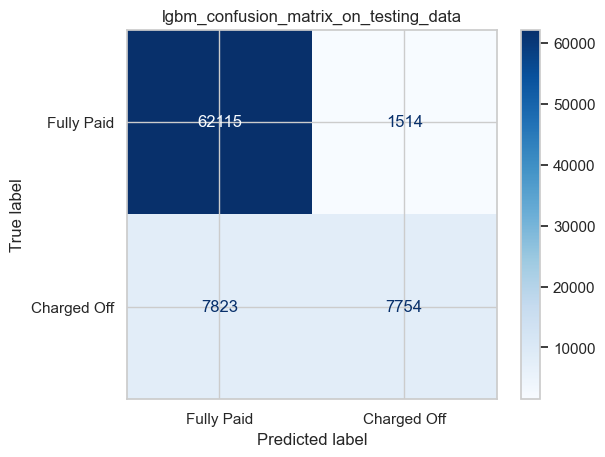

INFO:flaml.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://github.com/microsoft/FLAML/wiki/About-%60low_cost_partial_config%60


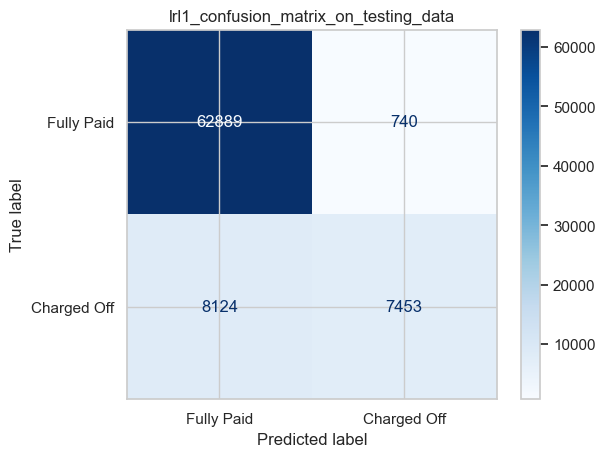

INFO:flaml.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://github.com/microsoft/FLAML/wiki/About-%60low_cost_partial_config%60


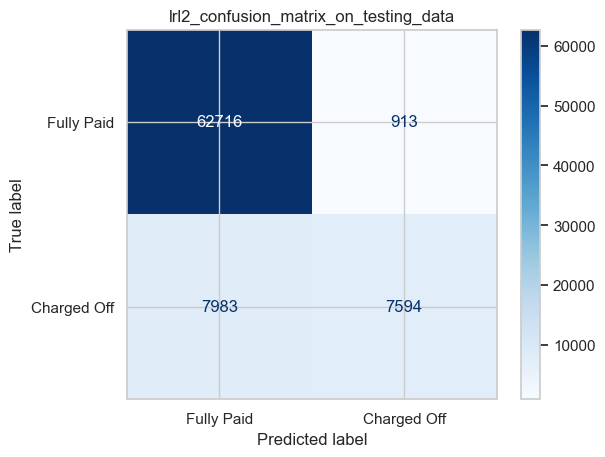

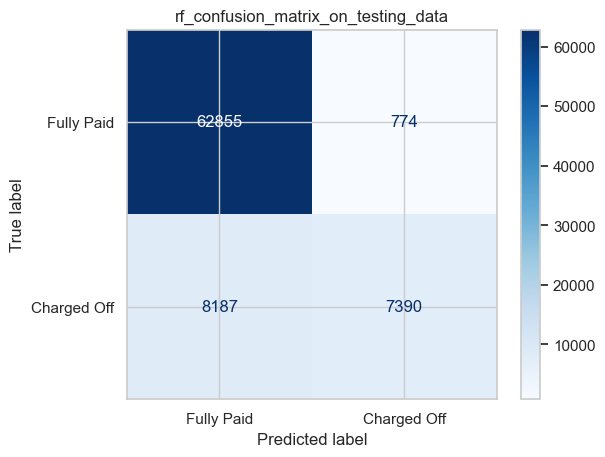

In [74]:
scores_dict={}
learners = ['ann', 'catboost', 'extra_tree', 'lgbm', 'lrl1', 'lrl2', 'rf']

automl = AutoML()
for i in learners:
    if i != 'ann':
        automl.fit(X_train = X_train_drop,
                   y_train = y_train,
                   task='classification',
                   time_budget=100,
                   metric='f1',
                   estimator_list=[i],
                   seed=123,
                   verbose = 0
                   #log_file_name='C:/Users/Lenovo/Desktop/Master Thesis/Lending Club/Best Parameters/training_logs.csv'
                   )
        np.save(f'C:\\Users\\Lenovo\\Desktop\\Master Thesis\\Best Params\\{i}_best_params.npy', automl.best_config)

        y_train_pred = automl.predict(X_train_drop)
        y_test_pred = automl.predict(X_test_drop)
        y_train_pred_proba = automl.predict_proba(X_train_drop)[:,1]
        y_test_pred_proba = automl.predict_proba(X_test_drop)[:,1]
    else:
        keras_classifier = StructuredDataClassifier(max_trials=10,
                                                    seed=312,
                                                    directory='C:\\Users\\Lenovo\\Desktop\\Master Thesis\\Best Params\\'
                                                    )
        np.object = object
        keras_classifier.fit(x=X_train_drop, y=y_train, verbose=0, epochs=5)
        model = keras_classifier.export_model()
        
        y_test_prob = model.predict(X_test_drop)
        y_train_prob = model.predict(X_train_drop)
        y_test_pred = keras_classifier.predict(X_test_drop)
        y_train_pred = keras_classifier.predict(X_train_drop)
    
    result = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['Fully Paid', 'Charged Off'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{i}_confusion_matrix_on_testing_data')
    plt.show()
    
    scores_dict[f'{i}'] = {
        'Train_ROC_AUC': roc_auc_score(y_train, y_train_pred_proba),
        'Test_ROC_AUC': roc_auc_score(y_test, y_test_pred_proba),
        'Train_PR_AUC': average_precision_score(y_train, y_train_pred_proba),
        'Test_PR_AUC': average_precision_score(y_test, y_test_pred_proba),
        'Train_brier_score': brier_score_loss(y_train, y_train_pred_proba),
        'Test_brier_score': brier_score_loss(y_test, y_test_pred_proba),
        'Train_accuracy_score': accuracy_score(y_train, y_train_pred),
        'Test_accuracy_score': accuracy_score(y_test, y_test_pred),
        'Train_f1_score':f1_score(y_train, y_train_pred),
        'Test_f1_score':f1_score(y_test, y_test_pred),
        }
    
scores_df = pd.DataFrame(scores_dict)

In [75]:
scores_df

,ann,catboost,extra_tree,lgbm,lrl1,lrl2,rf
Train_ROC_AUC,0.90,0.90,0.89,0.90,0.90,0.90,0.91
Test_ROC_AUC,0.90,0.90,0.89,0.90,0.90,0.90,0.90
Train_PR_AUC,0.77,0.77,0.75,0.77,0.77,0.77,0.80
Test_PR_AUC,0.77,0.77,0.75,0.76,0.77,0.77,0.77
Train_brier_score,0.08,0.08,0.10,0.08,0.08,0.08,0.08
Test_brier_score,0.08,0.08,0.10,0.09,0.08,0.08,0.08
Train_accuracy_score,0.89,0.89,0.88,0.89,0.89,0.89,0.90
Test_accuracy_score,0.89,0.89,0.88,0.88,0.89,0.89,0.89
Train_f1_score,0.62,0.63,0.57,0.64,0.63,0.63,0.66
Test_f1_score,0.62,0.62,0.57,0.62,0.63,0.63,0.62


# CONCLUSION
Performance metrics across models are comparable and do not exhibit any drastic difference. It can be concluded on this dataset that there is no performance differentiation between autokeras and flaml